In [7]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Linking Lya velocity offset to bubble size

If only Lya with a given velocity offset can escape IGM with high transmission, can we infer minimum bubble size?

# Lya cross-section

This looks fine

1210.81064713464 Angstrom 1221.2340259037169 Angstrom


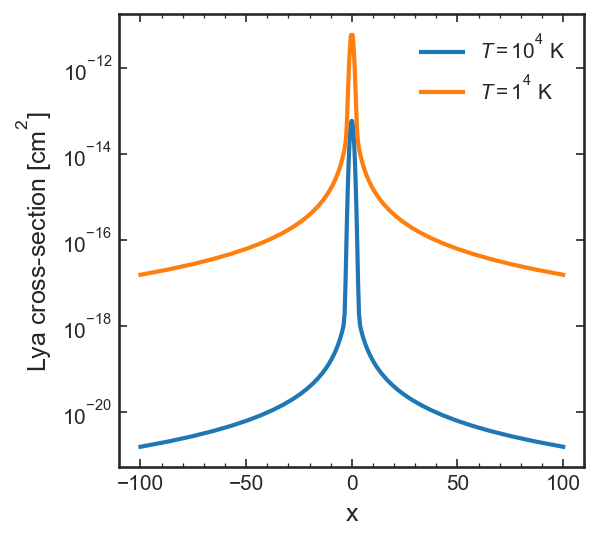

In [340]:
xtab_neg = -np.logspace(-1,2)
xtab_pos = np.logspace(-1,2)
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

plt.semilogy(xtab, bubbles.Lya_crosssec(wave=bubbles.Lya_x_to_wave(xtab, T=1e4*u.K), T=1e4*u.K), label='$T = 10^4$ K')
plt.semilogy(xtab, bubbles.Lya_crosssec(wave=bubbles.Lya_x_to_wave(xtab, T=1*u.K), T=1.*u.K), label='$T = 1^4$ K')

plt.legend()

plt.xlabel('x')
plt.ylabel('Lya cross-section [cm$^2$]')

print(bubbles.Lya_x_to_wave(xtab, T=1e4*u.K).min(), bubbles.Lya_x_to_wave(xtab, T=1e4*u.K).max())

# Estimate neutral fraction in a bubble

Use [Cen & Haiman (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...542L..75C/abstract), [Haiman (2004)](https://ui.adsabs.harvard.edu/abs/2002ApJ...576L...1H/abstract), [Mesinger, Haiman & Cen (2004)](https://ui.adsabs.harvard.edu/abs/2004ApJ...613...23M/abstract)

## Bubble size

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


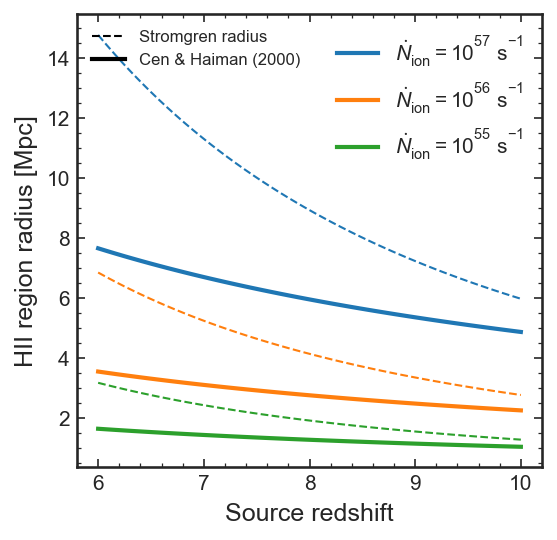

In [6]:
ztab = np.linspace(6., 10)

Ndot_ion_tab = [1.e57, 1.e56, 1.e55]

for Ndot_ion in Ndot_ion_tab:
    
    ln = plt.plot(ztab, bubbles.R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion/u.s),
                 ls='dashed', lw=1)  
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=Ndot_ion/u.s, 
                                          t_source=1.e8*u.yr),
             c=ln[0].get_color(),
             label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion))


stromgren_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='Stromgren radius')
CenHaiman_line = mlines.Line2D([], [], color='k', lw=2, label='Cen & Haiman (2000)')

leg = plt.legend(handles=[stromgren_line, CenHaiman_line], loc='upper left', fontsize=8)
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [Mpc]')

plt.savefig('../figs/R_HII_compare.pdf')

### Change age

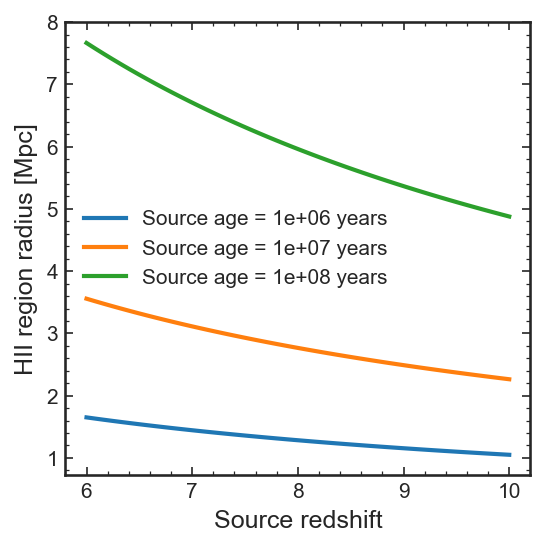

In [7]:
ztab = np.linspace(6., 10)

age_tab = np.logspace(-1, 1, 3)*1e7*u.year

for age in age_tab:
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=1e57/u.s, 
                                                  t_source=age),
             label='Source age = %.0e years' % age.value)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [Mpc]')

plt.savefig('../figs/R_HII_age.pdf')

## Ionized fraction

In [12]:
Rtab = np.logspace(-2., 1.5) * u.Mpc

### As a function of Nion

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


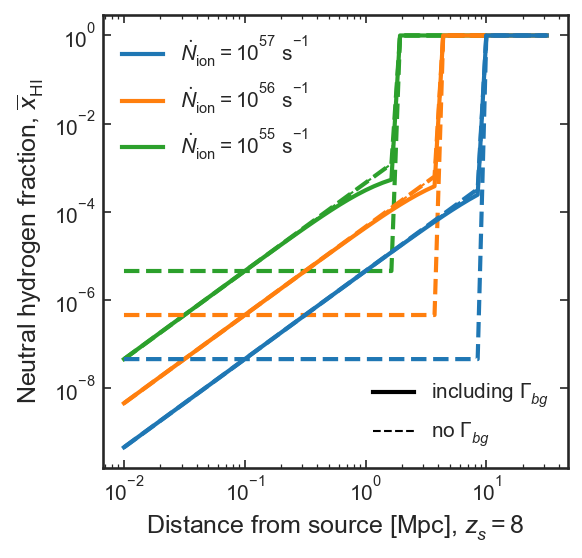

In [116]:
def xHI_approx(xHI_01, Rtab, R_HII, r_slope=2.):
    """
    Approximate xHI using a single value at 0.1 Mpc
    """
    xHI = xHI_01 * (10*Rtab.value)**r_slope
    xHI[Rtab > R_HII] = 1.
    return xHI
    
z_s = 8.

fesc_tab = [1, 0.1, 0.01]
for fesc in fesc_tab:
    
    Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

    R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=False)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1, ls='dashed')

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=True)    
    xHI_radial[Rtab > R_HII] = 1.
    
    plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=2, c=ln[0].get_color(),
               label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    xHI_01 = (xHI_radial[np.abs(Rtab.value - 0.1) < 0.005])[0]
    xHI = xHI_approx(xHI_01, Rtab, R_HII)
    
    plt.loglog(Rtab, xHI, zorder=fesc, lw=2, ls='dashed', c=ln[0].get_color())
    
    xHI = xHI_approx(xHI_01, Rtab, R_HII, r_slope=0.)
    plt.loglog(Rtab, xHI, zorder=fesc, lw=2, ls='dashed', c=ln[0].get_color())
               
background_line   = mlines.Line2D([], [], color='k', lw=2, label='including $\Gamma_{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='no $\Gamma_{bg}$')

leg = plt.legend(handles=[background_line, nobackground_line], loc='lower right')
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_withbg_zs=%.0f.pdf' % z_s)

### As a function of spectral index

1.9935457956050737e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s


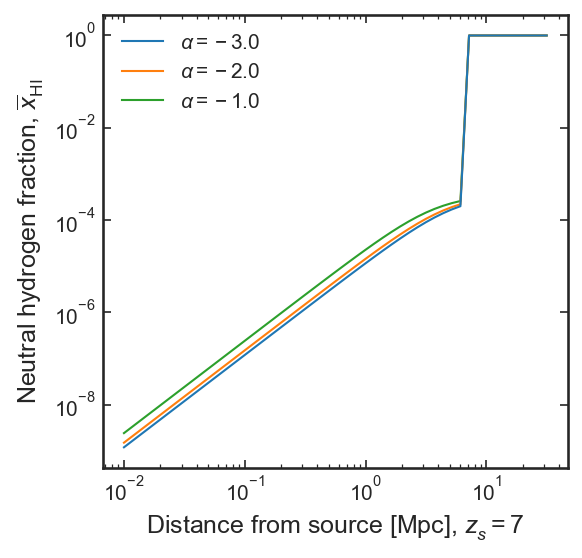

In [17]:
fesc_scale = 0.1
Ndot_ion_18 = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=-1.8)
z_s = 7.

alpha_tab = [-3, -2, -1.]
for alpha in alpha_tab:
    
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=alpha)

    fesc = fesc_scale * Ndot_ion_18/Ndot_ion
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc, qso=True, alpha=alpha)
    print(Ndot_ion, Ndot_ion_18)

    R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc, J_bg=True, alpha=alpha)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1,
                   label=r'$\alpha = %.1f$' % alpha)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_spectralindex.pdf')

### As a function of temperatures

Text(0, 0.5, 'Case B recombination coefficient [cm$^3$ s$^{-1}$]')

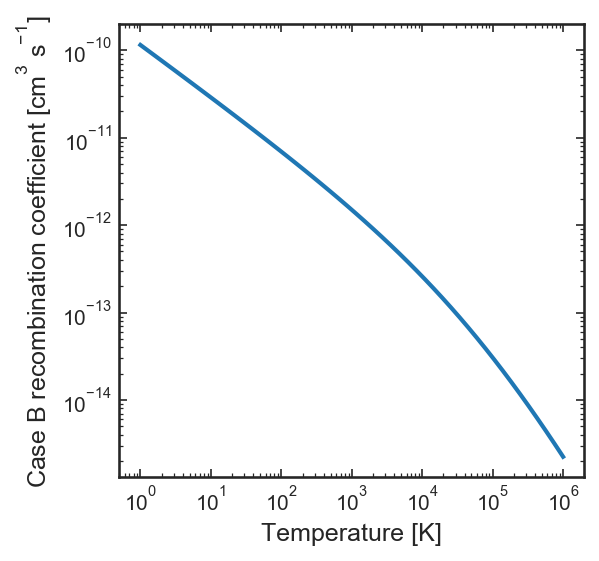

In [18]:
T = np.logspace(0, 6)

plt.loglog(T, bubbles.alpha_rec_B(T))

plt.xlabel('Temperature [K]')
plt.ylabel('Case B recombination coefficient [cm$^3$ s$^{-1}$]')

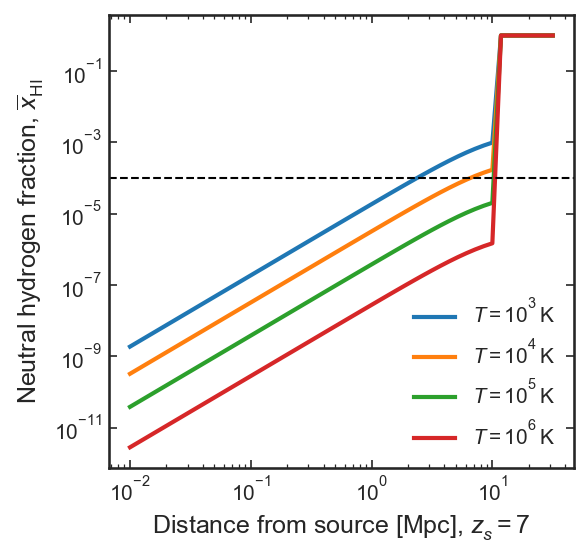

In [19]:
Ndot_ion_18 = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=0.5, qso=True, alpha=-1.8)

z_s = 7.
R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion_18)

T_tab = [1e3, 1e4, 1e5, 1e6]
for T in T_tab:
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=0.5, J_bg=True, T=T)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=2,
                   label=r'$T = 10^{%.0f}\,$K' % np.log10(T))

plt.axhline(1e-4, ls='dashed', lw=1, c='k')

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_temperature.pdf')

## Ionization front ODE

$$ \frac{dR^3}{dt} = 3 H(z) R^3 + \frac{3 \dot{N}_{ion}}{4\pi n_H} - C n_H \alpha_B R^3$$

$$ \frac{dR^3}{dz} + \frac{C n_H \alpha_B - 3 H(z)}{(1+z)H(z)} R^3 = \frac{3 \dot{N}_{ion}}{4\pi n_H (1+z)H(z)}$$

$\alpha_B = 2.59\times^{-13}$ cm^3/s (Draine p. 138, table 14.1)


In [6]:
def ionization_front_ionizations(z, Ndot_ion=1.e57/u.s):
    return (0.75 * Ndot_ion / (np.pi * bubbles.n_H(z))).to(u.Mpc**3./u.yr)

def ionization_front_recombinations(z, R=1.*u.Mpc, C=3, a_B=2.59e-13*u.cm**3./u.s):
    return (-a_B * C * bubbles.n_H(z) * R**3.).to(u.Mpc**3./u.yr)

def ionization_front_Hubble(z, R=1.*u.Mpc):
    return (3* Planck15.H(z) * R**3.).to(u.Mpc**3./u.yr)

[428.16596787 411.94013506 396.70885551 382.38929639 368.90723174
 356.19598213 344.19550407 332.85160544 322.11526746 311.94205697
 302.29161552 293.12721401 284.4153634  276.12547363 268.22955387
 260.70194868 253.51910498 246.65936604 240.10278867 233.83098094
 227.8269576  222.07501116 216.56059662 211.27022829 206.19138724
 201.31243807 196.62255407 192.1116497  187.77031961 183.58978353
 179.56183631 175.67880261 171.93349577 168.31918034 164.82953801
 161.45863651 158.20090118 155.05108903 152.00426495 149.05577996
 146.20125117 143.43654345 140.75775252 138.16118944 135.64336625
 133.2009828  130.83091449 128.53020107 126.29603614 124.12575755] Mpc


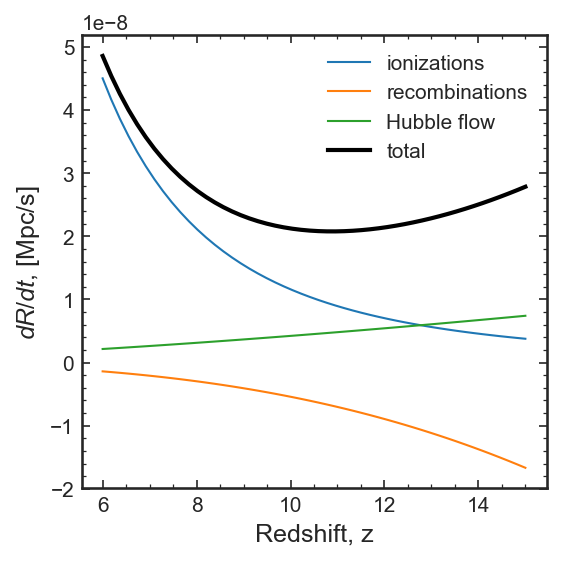

In [8]:
ztab = np.linspace(6, 15.)

horizon = (const.c/Planck15.H(z=ztab)).to(u.Mpc)
print(horizon)

R = 1.*u.Mpc
Ndot_ion = 1.e55/u.s

dRdt_ion = ionization_front_ionizations(ztab, Ndot_ion=Ndot_ion)
dRdt_rec = ionization_front_recombinations(ztab, R=R)
dRdt_Hub = ionization_front_Hubble(ztab, R=R)

plt.plot(ztab, dRdt_ion, lw=1, label='ionizations')
plt.plot(ztab, dRdt_rec, lw=1, label='recombinations')
plt.plot(ztab, dRdt_Hub, lw=1, label='Hubble flow')

plt.plot(ztab, dRdt_ion - dRdt_rec + dRdt_Hub, c='k', label='total')

plt.xlabel('Redshift, z')
plt.ylabel('$dR/dt$, [Mpc/s]')

plt.legend()

### Solve ODE

In [216]:
# Define a function which calculates the derivative
def dR3_dt(t, R3, z_s0=10, Ndot_ion=1.e55/u.s,):
  #         Ndot_ion_type='constant', Ndot_ion_alpha=-2.):
    """
    Rate of growth of R^3 ionization front
    in Mpc/yr
    
    NB: for solve_ivp must be fun(t, y)
    """
    # Age of universe when source turned on
    t_source_on     = Planck15.age(z=z_s0)
    
    # At age of source, t, what is redshift?
    t_now = t*u.yr + t_source_on
    try:
        z_tab_sourceage = np.array([z_at_value(Planck15.age, time) for time in t_now])
    except:
        z_tab_sourceage = z_at_value(Planck15.age, t_now)

    R = R3**(1./3.) * u.Mpc
    
#     # Ndot_ion
#     if Ndot_ion
#     Ndot_ion_burst(t, burst_freq=5e7*u.yr, burst_height=1.e57/u.s,
                   
#     print(t, Ndot_ion)           
    # Components of ionization front growth
    # All in Mpc**3/yr
    dR3dt_ion = ionization_front_ionizations(z_s0, Ndot_ion=Ndot_ion).value
    dR3dt_rec = ionization_front_recombinations(z_s0, R=R).value
    dR3dt_Hub = ionization_front_Hubble(z_tab_sourceage, R=R).value
    
    return dR3dt_ion - dR3dt_rec + dR3dt_Hub

In [65]:
%timeit solve_ivp(fun=lambda t, y: dR3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, method='RK23', vectorized=True, )
%timeit odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)

578 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
951 ms ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


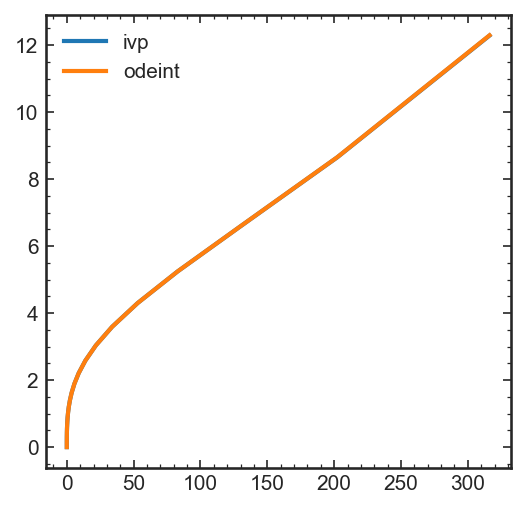

In [67]:
z_s0     = 10
# Redshift source turned on
Ndot_ion = 1e57/u.s
t_tab    = np.logspace(-1, 8.5)
# t_tab = np.linspace(0, 3e8)
args=z_s0, Ndot_ion
sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_ivp = sol.y.T**(1/3.)

R3 = odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)
R_odeint = R3.T[0]**(1/3.)

plt.plot(t_tab/1e6, R_ivp, label='ivp')
plt.plot(t_tab/1e6, R_odeint, label='odeint')
plt.legend()

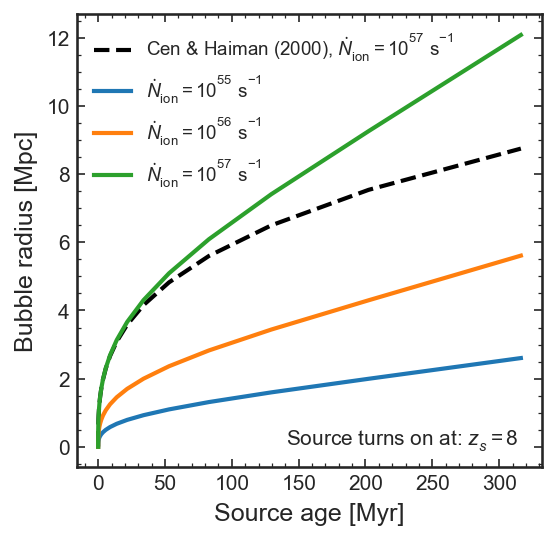

In [30]:
t_tab = np.linspace(0, 3e8)
t_tab = np.logspace(-1, 8.5)

z_s0 = 8 # Redshift source turned on

Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

plt.plot(t_tab/1e6, R_bubble_CenHaiman2000(z_s0, Ndot_ion=1.e57/u.s, t_source=t_tab*u.yr), 
         ls='dashed', c='k', label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{57}$ s$^{-1}$')

for Ndot_ion in Ndot_ion_tab:
    
    R3 = odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)

    R = R3.T[0]**(1/3.)
    
    plt.plot(t_tab/1e6, R, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
#     plt.semilogx(t_tab, R/R_S, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    
plt.annotate('Source turns on at: $z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')
    
plt.xlabel('Source age [Myr]')
plt.ylabel('Bubble radius [Mpc]')

plt.legend(fontsize=9)

plt.savefig('../figs/R_HII_age_compareCH00.pdf', bbox_inches='tight')

### Fluctuating Nion

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in power


Text(0, 0.5, '$\\dot{N}_\\mathrm{ion}$ [s$^{-1}$]')

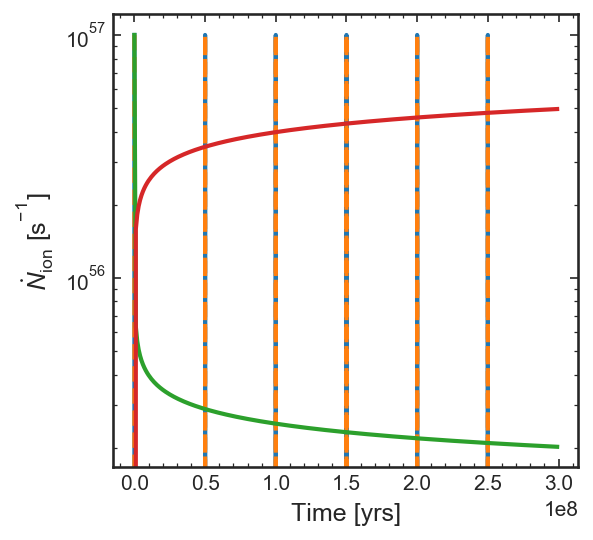

In [222]:
def Ndot_ion_burst(t, burst_freq=5e7*u.yr, burst_height=1.e57, min_diff=1e6):
    """
    Make Ndot_ion equally spaced bursts every burst_freq years
    """
    try: # if array
        bursts = np.arange(0, max(t)+1, burst_freq.value)
        Ndot_ion = np.zeros(len(t))
#         burst_match = [np.abs(burst - t) < min_diff for burst in bursts]
        Ndot_ion[np.in1d(t, bursts)] = burst_height
    except: # float
        bursts = np.arange(0, t+1, burst_freq.value)
#         print(bursts - t)
        if np.any(np.abs(bursts - t) < min_diff):
            Ndot_ion = burst_height
        else:
            Ndot_ion = 0.
        
    return Ndot_ion

def Ndot_ion_powerlaw(t, alpha=-2., Ndot_ion_0=1.e57):
    try:
        if t < 1:
            Ndot_ion = Ndot_ion_0
        else:
            Ndot_ion = Ndot_ion_0 * t**alpha
    except:
        Ndot_ion = Ndot_ion_0 * t**alpha
        Ndot_ion[~np.isfinite(Ndot_ion)] = Ndot_ion_0
    return Ndot_ion

t_tab = np.arange(0., 3e8, 1e6)
# print(Ndot_ion_burst(t_tab))
# t_tab = np.logspace(-1, 8.5, 100)
plt.plot(t_tab, Ndot_ion_burst(t_tab))
plt.plot(t_tab, np.array([Ndot_ion_burst(t) for t in t_tab]), ls='dashed')
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=-0.2))    
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=0.2, Ndot_ion_0=1.e55))    

plt.xlabel('Time [yrs]')
plt.ylabel('$\dot{N}_\mathrm{ion}$ [s$^{-1}$]')

In [232]:
z_s0     = 10 # Redshift source turned on
Ndot_ion = 1e57/u.s

t_tab = np.arange(0., 5e8, 1e6)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_const = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_burst(t, burst_height=1e58)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_burst = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=-0.1)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_decline = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=0.2, Ndot_ion_0=1.e55)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_increase = sol.y.T**(1/3.)

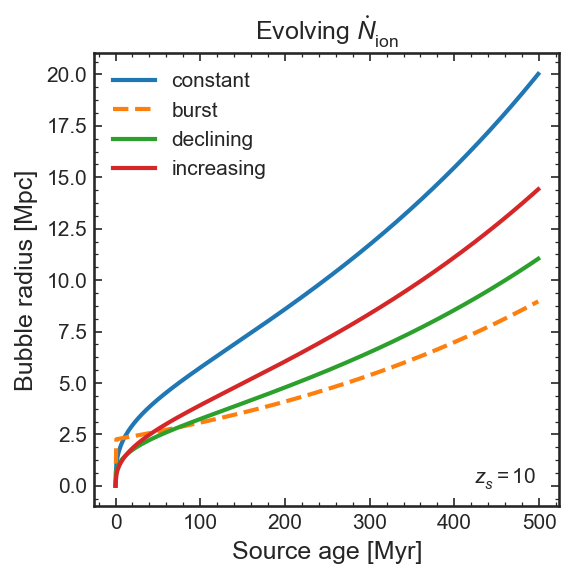

In [234]:
plt.plot(t_tab/1e6, R_const, label='constant')
plt.plot(t_tab/1e6, R_burst, ls='dashed', label='burst')
plt.plot(t_tab/1e6, R_decline, label='declining')
plt.plot(t_tab/1e6, R_increase, label='increasing')

plt.legend()
    
plt.annotate('$z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')

plt.title('Evolving $\dot{N}_\mathrm{ion}$')

plt.xlabel('Source age [Myr]')
plt.ylabel('Bubble radius [Mpc]')


plt.savefig('../figs/R_HII_age_evolving_Nion.pdf', bbox_inches='tight')

# Optical depth

$$ \tau(\lambda_{obs, z_s}) = \int_{z_0}^{z_s} \, dz \; c \frac{dt}{dz} n_H(z) \sigma_\alpha(\lambda_{obs}/(1+z)) $$

Neutral hydrogen density depends on HI fraction, calculate this inside the HII regions:

$$ n_H(z) = n_{H,0}(z) x_{HI}$$

In [14]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

def optical_depth(wave_em, T, z_min, z_max, z_s=7.,
                  inside_HII=True, C_HII=3.,
                  Ndot_ion=1.e57/u.s):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section
    """
    
    # Redshift array
    ztab_ends = np.array([z_min, z_max])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x
    wave_z_ends = wave_obs[:,None]/(1+ztab_ends)
    x_z_ends    = bubbles.Lya_wave_to_x(wave_z_ends, T=T)

    tau = np.zeros(len(wave_obs))
    for ww, w_obs in enumerate(wave_obs):
                
        # Make xtab 
        if (x_z_ends[ww] < 0).all():
            xtab = -np.logspace(np.log10(-x_z_ends[ww].min()),np.log10(-x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        elif (x_z_ends[ww] > 0).all():
            xtab = np.logspace(np.log10(x_z_ends[ww].min()),np.log10(x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        else:       
            xtab_neg = -np.logspace(-1,np.log10(-x_z_ends[ww].min()),50)
            xtab_pos = np.logspace(-1,np.log10(x_z_ends[ww].max()),50)
            xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))
        
        # Get wave_redshift
        wave_redshift = bubbles.Lya_x_to_wave(xtab, T=T)

        # Get z tab
        ztab = w_obs/wave_redshift - 1.

        # Residual neutral fraction
        if inside_HII:
            r   = bubbles.comoving_distance_from_source_Mpc(ztab, z_s)
            xHI = bubbles.xHI_R(r, z_s, fesc=0.5*Ndot_ion/(1.e57/u.s), C=C_HII, T=T.value) # Only source flux
        else:
            xHI = 1.
            
        # Cross-section
        lya_cross = bubbles.Lya_crosssec(wave_redshift, T=T)
                           
        # Calculate optical depth
        prefac = (const.c * bubbles.dt_dz(ztab) * xHI * bubbles.n_H(ztab)).to(1./u.cm**2.)
        dtau   = prefac * lya_cross
    
        tau[ww] = np.trapz(dtau, ztab)
        
    return tau

def make_tau(Ndot_ion, source_age, z_s=7., z_min=6.):
    
    R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=source_age)
    z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

    # inside bubble
    tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

    # in IGM
    tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                            inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

    tau_total = tau_IGM + tau_HII
    
    tau_tab = tau_HII, tau_IGM, tau_total
    return tau_tab, R_ion

In [126]:
def plot_tau(tau_tab, wave_em, R_ion, transmission=False, 
             ax=None, annotate=True):
    
    tau_HII, tau_IGM, tau_total = tau_tab
    
    if transmission:
        tau_HII, tau_IGM, tau_total = np.exp(-tau_HII), np.exp(-tau_IGM), np.exp(-tau_total)
        ylabel = r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$'
    else:
        ylabel = r'Optical depth $\tau_{\mathrm{Ly}\alpha}$'
    
    # Make DV table
    DV_tab = bubbles.wave_to_DV(wave_em)

    if ax is None:
        fig, ax_wave = plt.subplots(1,1)
    else:
        ax_wave=ax

    ax_wave.plot(wave_em, tau_HII, lw=1, ls='dashed', label='inside HII region')
    ax_wave.plot(wave_em, tau_IGM, lw=1, ls='dotted', label='IGM')
    ax_wave.plot(wave_em, tau_total, label='total')

    # DV plot
    ax_DV = ax_wave.twiny()
    ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

    ax_wave.legend(loc='upper right')#, frameon=True)
    
    if transmission:
        plt.yscale('linear')
        ax_wave.set_ylim(-0.1, 1.1)
    else:
        plt.yscale('log')
        ax_wave.set_ylim(1e-6, 1.2e6)
        
    ax_DV.set_xlim(-1000, 1000)
    ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    if annotate:
        ax_wave.annotate('$R_{HII}=%.1f$ Mpc' % R_ion.value, xy=(0.98, 0.05), xycoords='axes fraction', ha='right')
    
    ax_wave.set_ylabel(ylabel)
    ax_wave.set_xlabel('Wavelength [A]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    
    plt.tight_layout()
    
    return

def plot_tau_single(tau, wave_em, annotation='', transmission=False, 
                     ax=None, annotate=True, label=None):
        
    if transmission:
        tau = np.exp(-tau)
        ylabel = r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$'
    else:
        ylabel = r'Optical depth $\tau_{\mathrm{Ly}\alpha}$'
    
    # Make DV table
    DV_tab = bubbles.wave_to_DV(wave_em)

    if ax is None:
        fig, ax_wave = plt.subplots(1,1)
    else:
        ax_wave=ax

    ax_wave.plot(wave_em, tau, label=label)

    # DV plot
    ax_DV = ax_wave.twiny()
    ax_DV.semilogy(DV_tab, tau, lw=0)

    ax_wave.legend(loc='upper right')#, frameon=True)
    
    if transmission:
        plt.yscale('linear')
        ax_wave.set_ylim(-0.1, 1.1)
    else:
        plt.yscale('log')
        ax_wave.set_ylim(1e-6, 1.2e6)
        
    ax_DV.set_xlim(-1000, 1000)
    ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

    if annotate:
        ax_wave.annotate(annotation, xy=(0.98, 0.05), xycoords='axes fraction', ha='right')
    
    ax_wave.set_ylabel(ylabel)
    ax_wave.set_xlabel('Wavelength [A]')
    ax_DV.set_xlabel('Velocity offset [km/s]')
    
    plt.tight_layout()
    
    return

## Simple case with Stromgren sphere

In [26]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

z_s   = 7.
z_min = 6.

Ndot_ion = 1.e57/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

print(R_ion, z_ion)

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

3.1130177630958102 Mpc 6.991125391413053


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, 'Velocity offset [km/s]')

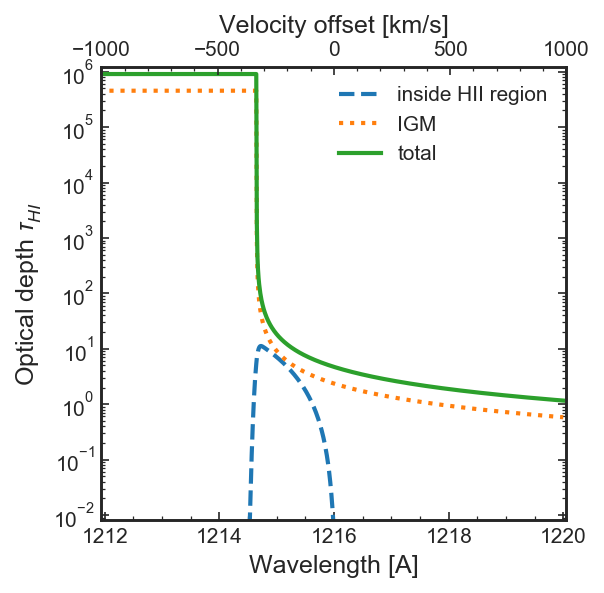

In [29]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1)

ax_wave.semilogy(wave_em, tau_HII, ls='dashed', label='inside HII region')
ax_wave.semilogy(wave_em, tau_IGM, ls='dotted', label='IGM')

tau_total = tau_IGM + tau_IGM

ax_wave.semilogy(wave_em, tau_total, label='total')

ax_DV = ax_wave.twiny()
ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

ax_wave.legend()
ax_wave.set_ylim(0.8e-2, 1.2e6)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Optical depth $\tau_{HI}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

## Cen & Haiman

In [30]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)
z_min = 6.

print(R_ion, z_ion)

wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total = tau_IGM + tau_HII

1.8205038317327773 Mpc 6.9948100974144145


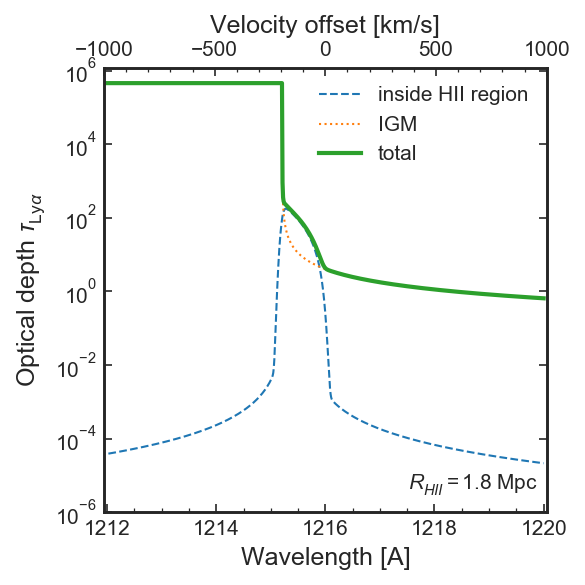

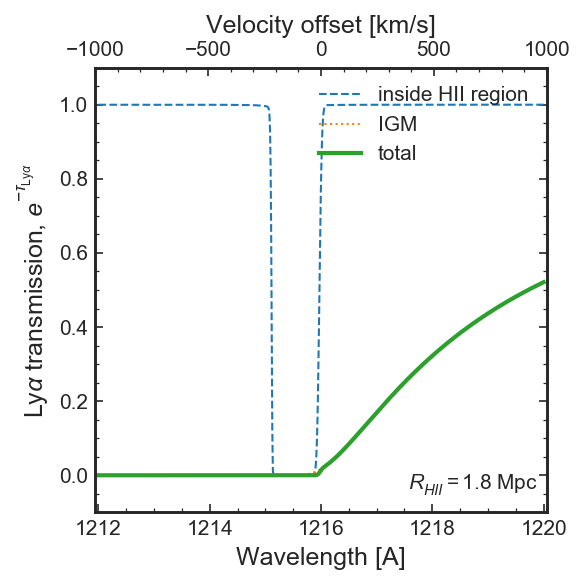

In [31]:
tau_tab = tau_HII, tau_IGM, tau_total

plot_tau(tau_tab, wave_em, R_ion, transmission=False)
plot_tau(tau_tab, wave_em, R_ion, transmission=True)

### Function of temperature

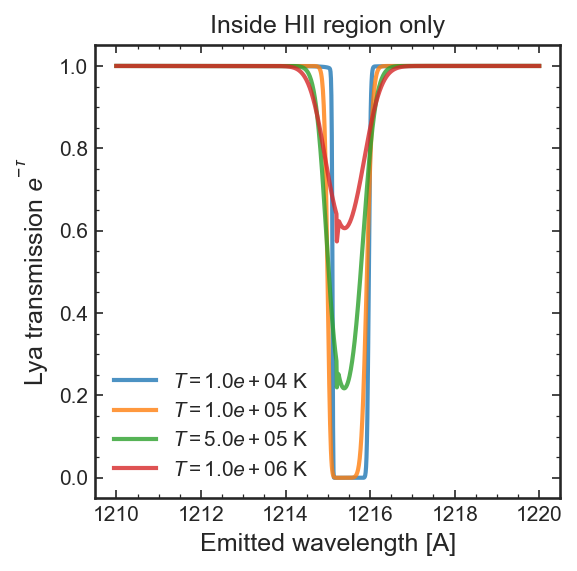

In [72]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)
z_min = 6.

T_tab = [1e4, 1e5, 5e5, 1e6]

for T in T_tab:
    tau_HII_T = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                              inside_HII=True, T=T*u.K, Ndot_ion=Ndot_ion)
    
#     plt.semilogy(wave_em, (tau_HII_T), label='$T=%.1e$ K' % T)
    plt.plot(wave_em, np.exp(-tau_HII_T), label='$T=%.1e$ K' % T, alpha=0.8)

plt.xlabel('Emitted wavelength [A]')
# plt.ylabel(r'Lya optical depth $\tau$')
plt.ylabel(r'Lya transmission $e^{-\tau}$')

plt.title('Inside HII region only')

plt.legend()

### Make animation

#### Update Nion

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


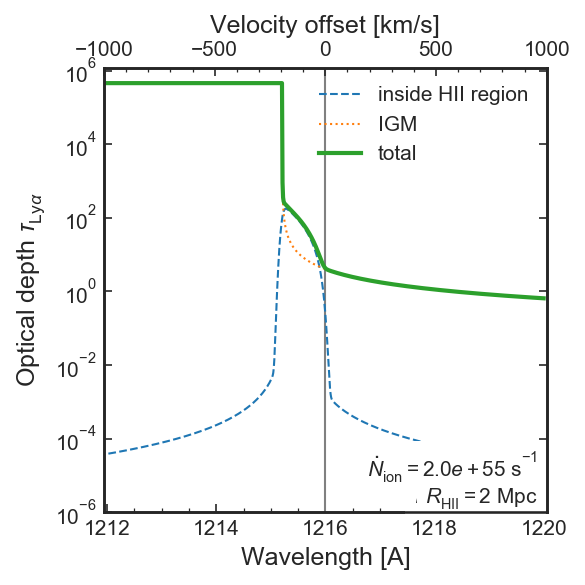

In [576]:
transmission = True
Ndot_ion_tab = np.logspace(-2, 1, 10)*2e57/u.s

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_Nion(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[i], source_age=1e8*u.year, z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'$\dot{N}_\mathrm{ion}=%.1e$ s$^{-1}$' % Ndot_ion_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[0], source_age=1e7*u.year, z_s=7., z_min=6.)
plot_tau(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau, frames=np.arange(len(Ndot_ion_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_Nion.gif'
else:
    plotname = '../figs/optdepth_animate_Nion.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

#### Update age

[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08] yr


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


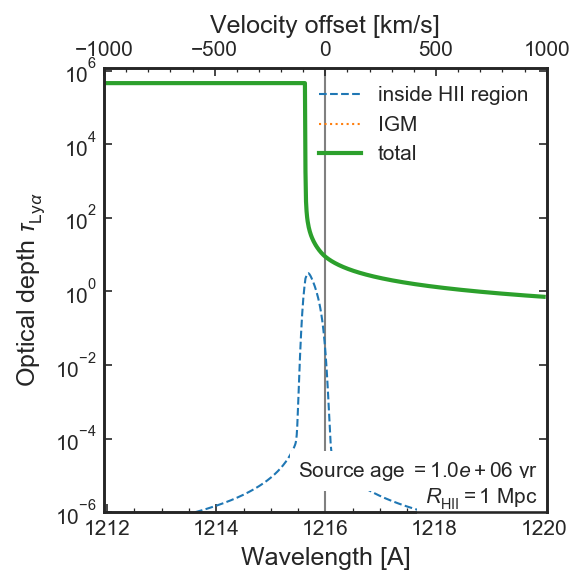

In [167]:
transmission = False
source_age_tab = np.logspace(-2, 0, 10)*1e8*u.year
print(source_age_tab)

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_age(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[i], z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'Source age $=%.1e$ yr' % source_age_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[0], z_s=7., z_min=6.)
plot_tau_all(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau_age, frames=np.arange(len(source_age_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_age.gif'
else:
    plotname = '../figs/optdepth_animate_age.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Optical depth on a grid of Nion

## Make a grid

In [7]:
z_s   = 7.
z_min = 6.
source_age = 1e7*u.year

Ndot_ion_tab = np.logspace(-3, 1, 50)*2e57/u.s
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion, source_age=source_age, z_s=z_s, z_min=z_min)
    print(Ndot_ion, R_ion)
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2e+54 1 / s 0.39221566084210635 Mpc
2.4135852812786578e+54 1 / s 0.41757627424212923 Mpc
2.912696955002489e+54 1 / s 0.4445767015920707 Mpc
3.515021249709583e+54 1 / s 0.4733229730477448 Mpc
4.241901775840381e+54 1 / s 0.5039279746609915 Mpc
5.119095845399072e+54 1 / s 0.5365118916810178 Mpc
6.177687192954963e+54 1 / s 0.5712026805195458 Mpc
7.455187440629877e+54 1 / s 0.6081365712331666 Mpc
8.996865337938889e+54 1 / s 0.6474586024961367 Mpc
1.0857350878647719e+55 1 / s 0.6893231911644454 Mpc
1.3102571137191018e+55 1 / s 0.7338947386678204 Mpc
1.5812086421815404e+55 1 / s 0.7813482766109624 Mpc
1.908190952699989e+55 1 / s 0.83187015411927 Mpc
2.302790798652894e+55 1 / s 0.8856587696282489 Mpc
2.7789909887462746e+55 1 / s 0.9429253499903317 Mpc
3.3536658736220156e+55 1 / s 1.0038947799586388 Mpc
4.047179295450313e+55 1 / s 1.0688064853050534 Mpc
4.884106189097302e+55 1 / s 1.1379153730405958 Mpc
5.89410340510362e+55 1 / s 1.2114928324303236 Mpc
7.112960612446256e+55 1 / s 1.289827800733

In [8]:
# Plot
s_m = bubbles.scalar_mappable(R_ion_tab, cmap='plasma_r')

DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.3,4))
ax_DV = ax_wave.twiny()
    
for i, R_ion in enumerate(R_ion_tab):
#     if i % 4 == 0:
        ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=s_m.to_rgba(R_ion), lw=1, alpha=0.8, zorder=0)
        ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)

plt.colorbar(s_m, label='HII region radius [Mpc]')

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.tight_layout()
# plt.savefig('../figs/transmission_R_HII.pdf')

NameError: name 'mpl' is not defined

## Video of grid

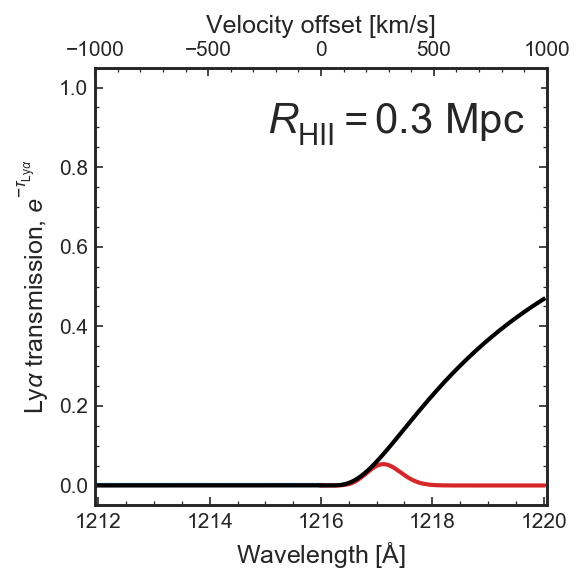

In [30]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4,4))
ax_DV = ax_wave.twiny()

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax_DV.set_xlabel('Velocity offset [km/s]')

def update_tau_R(i):
    # Get new tau and R_ion    
    # Plot
    ax_DV.lines[0].set_ydata(np.exp(-tau_tot_tab[i]))
    ax_DV.lines[1].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity < 0.])
    ax_DV.lines[2].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity >= 0.])
            
    # Annotate
    ax_wave.annotate(r'$R_\mathrm{HII}=%.1f$ Mpc' % np.round(R_ion_tab[i], 1), xy=(0.95, 0.85), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w', fontsize=20)
    
# First one
ax_wave.plot(wave_em, np.exp(-tau_tot_tab[0]), lw=0, c='k')
ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[0]), lw=2, c='k')
ax_DV.plot(velocity[velocity < 0.],  (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity < 0.],  c='tab:blue', zorder=0)
ax_DV.plot(velocity[velocity >= 0.], (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity >= 0.], c='tab:red', zorder=0)

# ax_DV.plot(velocity[velocity < 0.],  400*lines[10][velocity < 0.],  c='tab:blue', zorder=0)
# ax_DV.plot(velocity[velocity >= 0.], 400*lines[10][velocity >= 0.], c='tab:red', zorder=0)


# Animate
anim_tau = FuncAnimation(fig, update_tau_R, frames=np.arange(len(R_ion_tab)), 
                         interval=200) # interval in ms

plotname = '../figs/transmission_animate_Rion_linear.gif'

plt.tight_layout()

# plt.savefig(plotname.replace('.gif','_lines.pdf'))
anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Make grid of R_HII, xHI(0.1 Mpc)

In [118]:
def optical_depth_grid(wave_em, T, z_min, z_max, z_s=7.,
                  inside_HII=True, C_HII=3., 
                  xHI_01=1e-8, R_ion=1.*u.Mpc,
                  r_slope=2.):
    """
    Lya optical depth as a function of wavelength 
    using definition of optical depth and Lya cross-section
    """
    
    # Redshift array
    ztab_ends = np.array([z_min, z_max])
    
    # Observed wavelength
    wave_obs = wave_em * (1. + z_s)
        
    # Range of redshifted wavelength and x
    wave_z_ends = wave_obs[:,None]/(1+ztab_ends)
    x_z_ends    = bubbles.Lya_wave_to_x(wave_z_ends, T=T)

    tau = np.zeros(len(wave_obs))
    for ww, w_obs in enumerate(wave_obs):
                
        # Make xtab 
        if (x_z_ends[ww] < 0).all():
            xtab = -np.logspace(np.log10(-x_z_ends[ww].min()),np.log10(-x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        elif (x_z_ends[ww] > 0).all():
            xtab = np.logspace(np.log10(x_z_ends[ww].min()),np.log10(x_z_ends[ww].max()),100)
            xtab = np.sort(xtab)
        else:       
            xtab_neg = -np.logspace(-1,np.log10(-x_z_ends[ww].min()),50)
            xtab_pos = np.logspace(-1,np.log10(x_z_ends[ww].max()),50)
            xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))
        
        # Get wave_redshift
        wave_redshift = bubbles.Lya_x_to_wave(xtab, T=T)

        # Get z tab
        ztab = w_obs/wave_redshift - 1.

        # Residual neutral fraction
        if inside_HII:
            r   = bubbles.comoving_distance_from_source_Mpc(ztab, z_s)
            xHI = xHI_approx(xHI_01, r, R_ion, r_slope=r_slope)
        else:
            xHI = 1.
            
        # Cross-section
        lya_cross = bubbles.Lya_crosssec(wave_redshift, T=T)
                           
        # Calculate optical depth
        prefac = (const.c * bubbles.dt_dz(ztab) * xHI * bubbles.n_H(ztab)).to(1./u.cm**2.)
        dtau   = prefac * lya_cross
    
        tau[ww] = np.trapz(dtau, ztab)
        
    return tau

def make_tau_grid(R_ion, xHI_01, r_slope=2., z_s=7., z_min=6.):
    
    z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

    # inside bubble
    tau_HII = optical_depth_grid(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                            inside_HII=True, T=1.e4*u.K,
                            xHI_01=xHI_01, R_ion=R_ion, r_slope=r_slope)

    # in IGM
    tau_IGM = optical_depth_grid(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                            inside_HII=False, T=1.*u.K,
                            xHI_01=xHI_01, R_ion=R_ion)

    tau_total = tau_IGM + tau_HII
    
    tau_tab = tau_HII, tau_IGM, tau_total
    return tau_tab

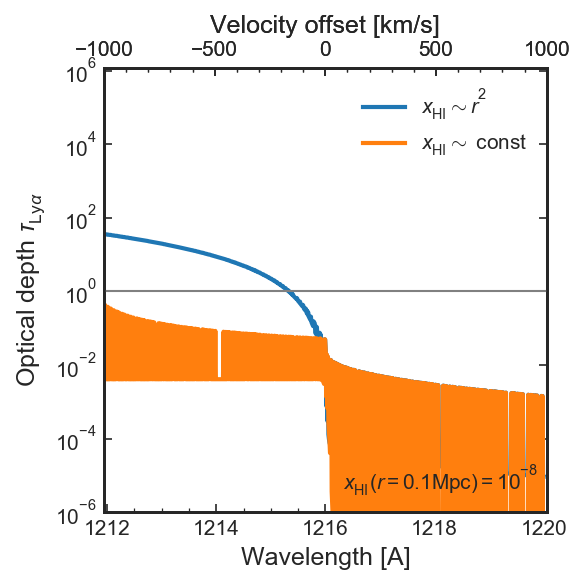

In [350]:
R_ion  = 10. * u.Mpc
xHI_01 = 1e-8

fig, ax = plt.subplots(1,1)

tau_tab = make_tau_grid(R_ion=R_ion, xHI_01=xHI_01)
plot_tau_single(tau_tab[0], wave_em, ax=ax, transmission=False, 
                annotation='$x_\mathrm{HI}(r=0.1$Mpc$) = 10^{%.0f}$' % np.log10(xHI_01), annotate=True,
                label='$x_\mathrm{HI} \sim r^2$')

tau_tab = make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=0.)
plot_tau_single(tau_tab[0], wave_em, ax=ax, transmission=False, label='$x_\mathrm{HI} \sim$ const')
plt.axhline(1, lw=1, c='0.5', zorder=0)

In [90]:
R_ion_tab  = np.arange(0.1, 10, 0.2) * u.Mpc
xHI_01_tab = np.logspace(-9, 0, 10)

print(R_ion_tab)
print(xHI_01_tab)

start = time.time()
tau_total_dict = {}
for R_ion, xHI_01 in it.product(R_ion_tab, xHI_01_tab):
    R_ion_key = np.round(R_ion, 2)
    xHI_01_key = np.round(np.log10(xHI_01),2)
    print(R_ion_key, xHI_01_key)
    
    tau_tab = make_tau_grid(R_ion=R_ion, xHI_01=xHI_01)
    tau_HII, tau_IGM, tau_total = tau_tab
    
    tau_total_dict[(R_ion_key, xHI_01_key)] = tau_total
    
    del tau_HII, tau_IGM, tau_total
    
end = time.time()
print(end - start)

np.save('../data/tau_total_dict_RHII_xHI_grid_linear', tau_total_dict)

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5
 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3 5.5 5.7 5.9 6.1 6.3 6.5 6.7 6.9 7.1
 7.3 7.5 7.7 7.9 8.1 8.3 8.5 8.7 8.9 9.1 9.3 9.5 9.7 9.9] Mpc
[1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
0.1 Mpc -9.0
0.1 Mpc -8.0
0.1 Mpc -7.0
0.1 Mpc -6.0
0.1 Mpc -5.0
0.1 Mpc -4.0
0.1 Mpc -3.0
0.1 Mpc -2.0
0.1 Mpc -1.0
0.1 Mpc 0.0
0.3 Mpc -9.0
0.3 Mpc -8.0
0.3 Mpc -7.0
0.3 Mpc -6.0
0.3 Mpc -5.0
0.3 Mpc -4.0
0.3 Mpc -3.0
0.3 Mpc -2.0
0.3 Mpc -1.0
0.3 Mpc 0.0
0.5 Mpc -9.0
0.5 Mpc -8.0
0.5 Mpc -7.0
0.5 Mpc -6.0
0.5 Mpc -5.0
0.5 Mpc -4.0
0.5 Mpc -3.0
0.5 Mpc -2.0
0.5 Mpc -1.0
0.5 Mpc 0.0
0.7 Mpc -9.0
0.7 Mpc -8.0
0.7 Mpc -7.0
0.7 Mpc -6.0
0.7 Mpc -5.0
0.7 Mpc -4.0
0.7 Mpc -3.0
0.7 Mpc -2.0
0.7 Mpc -1.0
0.7 Mpc 0.0
0.9 Mpc -9.0
0.9 Mpc -8.0
0.9 Mpc -7.0
0.9 Mpc -6.0
0.9 Mpc -5.0
0.9 Mpc -4.0
0.9 Mpc -3.0
0.9 Mpc -2.0
0.9 Mpc -1.0
0.9 Mpc 0.0
1.1 Mpc -9.0
1.1 Mpc -8.0
1.1 Mpc -7.0
1.1 Mpc -6.0
1.1 Mpc -5.0
1.1 Mpc -4

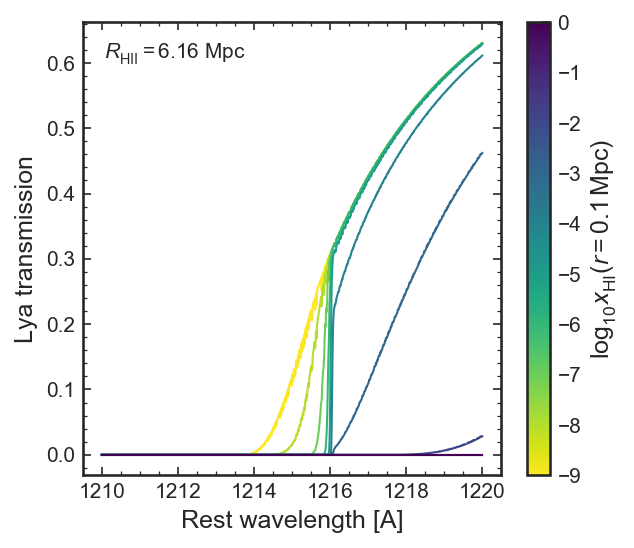

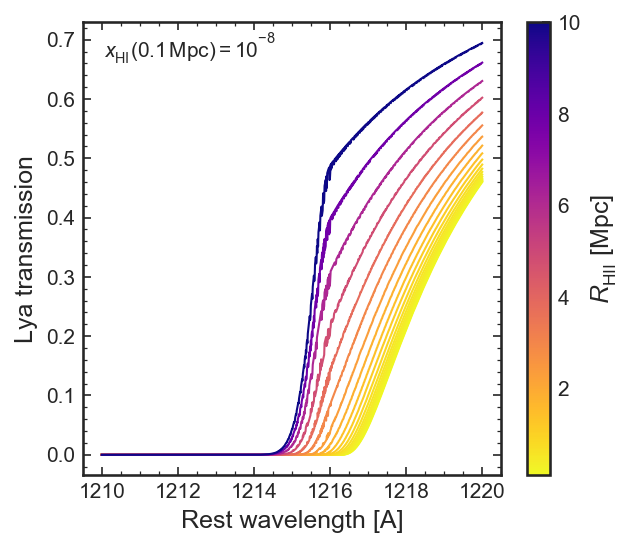

In [70]:
# Change xHI
s_m = bubbles.scalar_mappable(np.log10(xHI_01_tab), cmap='viridis_r')

plt.figure(figsize=(4.5,4))

R_ion_key  = 6.16*u.Mpc
for xHI_01 in (xHI_01_tab):
    xHI_01_key = np.round(np.log10(xHI_01),2)
    
    plt.plot(wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01_key)]), 
             c=s_m.to_rgba(xHI_01_key), alpha=1, lw=1)
    
plt.annotate('$R_\mathrm{HII} = $%s' % R_ion_key, xy=(0.05,0.92), xycoords='axes fraction')

plt.colorbar(s_m, label='$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
plt.xlabel('Rest wavelength [A]')
plt.ylabel('Lya transmission')

plt.savefig('../figs/transmission_xHI_change.pdf', bbox_inches='tight')

# Change R_HII
s_m = bubbles.scalar_mappable(R_ion_tab.value, cmap='plasma_r')

plt.figure(figsize=(4.5,4))

xHI_01_key  = -8.0
for R_ion in (R_ion_tab):
    R_ion_key = np.round(R_ion, 2)
    
    plt.plot(wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01_key)]), 
             c=s_m.to_rgba(R_ion_key.value), alpha=1, lw=1)
    
plt.annotate('$x_\mathrm{HI}(0.1\,$Mpc$) = 10^{%.0f}$' % xHI_01_key, xy=(0.05,0.92), xycoords='axes fraction')

plt.colorbar(s_m, label='$R_\mathrm{HII}$ [Mpc]')
plt.xlabel('Rest wavelength [A]')
plt.ylabel('Lya transmission')

plt.savefig('../figs/transmission_RHII_change.pdf', bbox_inches='tight')


# Add fake lines

## Grid of lines

Text(0, 0.5, 'Normalized Lya flux')

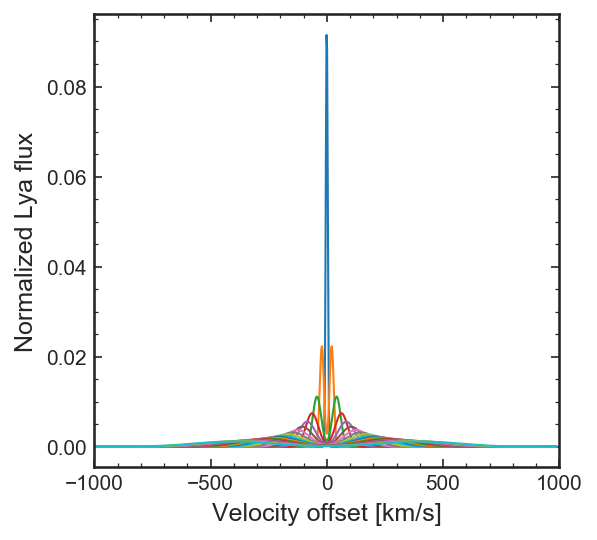

In [25]:
line_DV = np.linspace(-500., 500, 20)
line_DV = np.linspace(0., 400, 20)

velocity = bubbles.wave_to_DV(wave_em).value

# lines = np.array([reionizer.line_shape_gauss(v=velocity, vcenter=DV, fwhm=DV, vmin=-2000.) for DV in line_DV])
lines = np.array([bubbles.lineshape_doublepeak(v=velocity, vcenter=DV) for DV in line_DV])

plt.plot(velocity, lines.T, lw=1)

plt.xlim(-1000, 1000)

plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## Multiply by transmission

Text(0, 0.5, 'Normalized Lya flux')

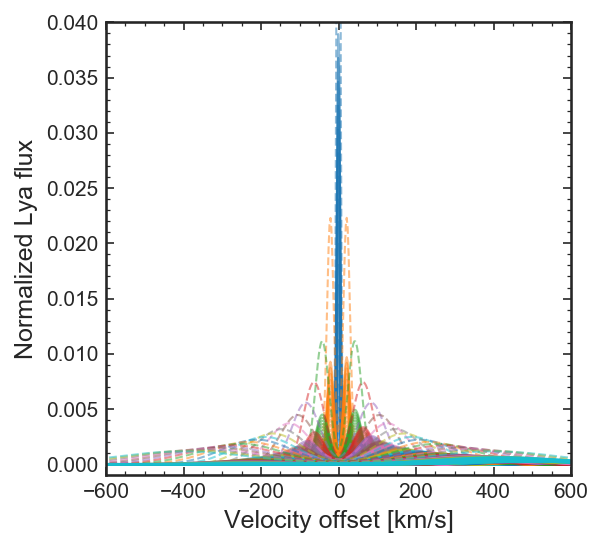

In [236]:
Tigm      = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_blue = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_red = np.zeros((len(lines), len(tau_tot_tab)))

for i, line in enumerate(lines):
    ln = plt.plot(velocity, line, lw=1, alpha=0.5, ls='dashed')
    
    trans_tot_tab = np.exp(-tau_tot_tab)
    plt.plot(velocity, (line*trans_tot_tab).T, c=ln[0].get_color(), lw=1, alpha=0.5)
    
    Tigm_blue[i] = 2*np.trapz(line[velocity < 0.]*trans_tot_tab.T[np.where(velocity < 0.)].T, velocity[velocity < 0.])
    Tigm_red[i]  = 2*np.trapz(line[velocity >= 0.]*trans_tot_tab.T[np.where(velocity >= 0.)].T, velocity[velocity >= 0.])
    Tigm[i]      = np.trapz(line*trans_tot_tab, velocity)
    
plt.xlim(-600, 600)
plt.ylim(-0.001, 0.04)
plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## Plot both transmissions

In [ ]:
plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_bluepeak.pdf', bbox_inches='tight')

## What is minimum R_HII required to see a blue peak?

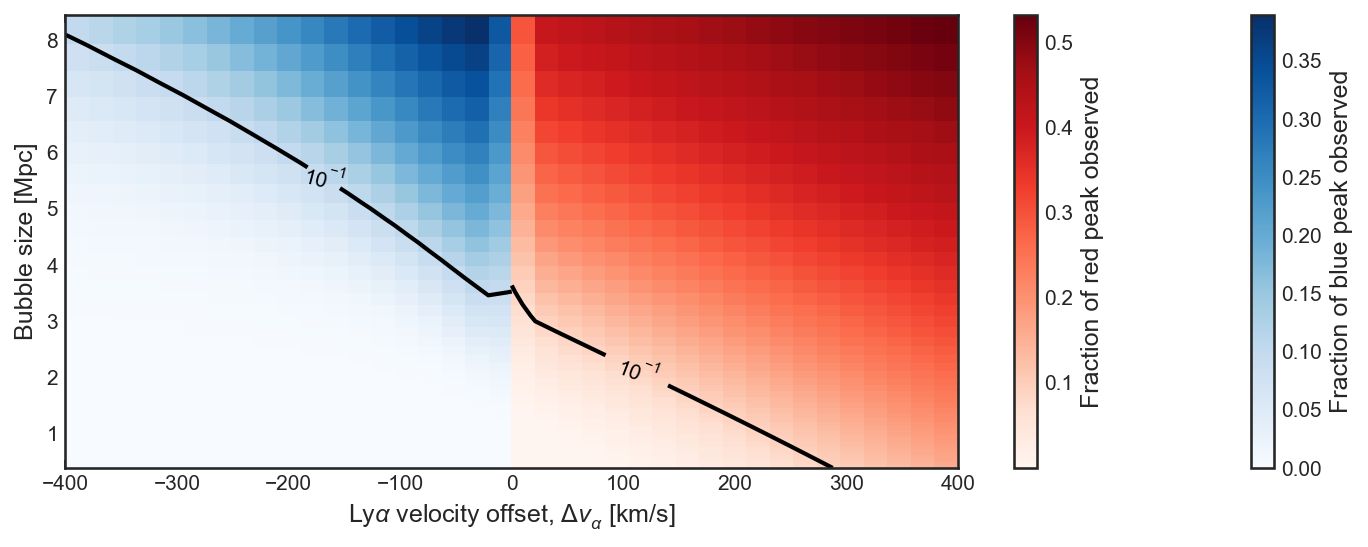

In [242]:
plt.figure(figsize=(12, 4))

im_blue = plt.pcolormesh(-line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im_blue, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(-line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

im_red = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im_red, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('../figs/transmission_bubblesize_deltav.pdf', bbox_inches='tight')

In [250]:
print(np.exp(-5), np.exp(-7))

0.006737946999085467 0.0009118819655545162


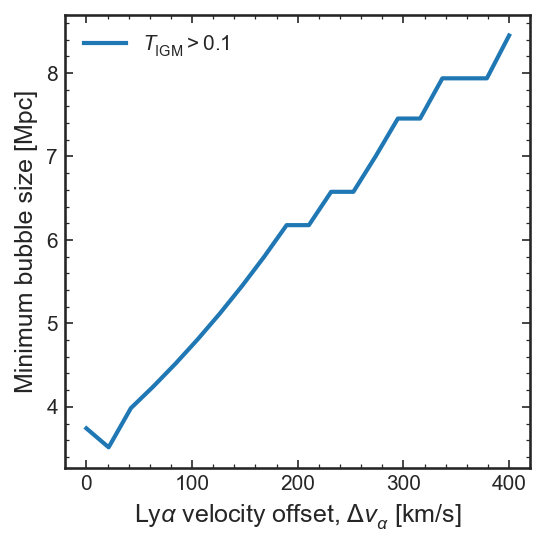

In [49]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_blue[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## What is minimum R_HII required to see red peak?

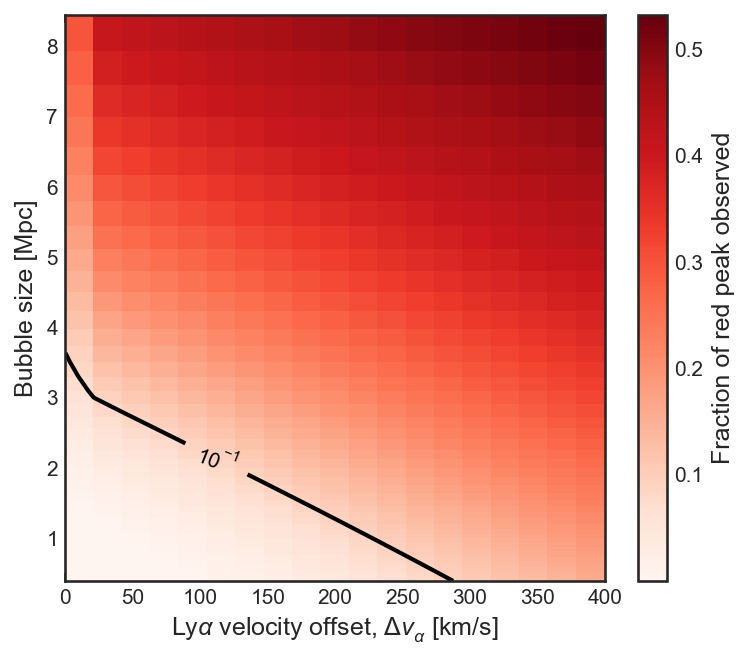

In [63]:
fig, ax = plt.subplots(1,1, figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')
# ax.set_yscale('log')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()

# locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.minorticks_on()
# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_redpeak.pdf', bbox_inches='tight')

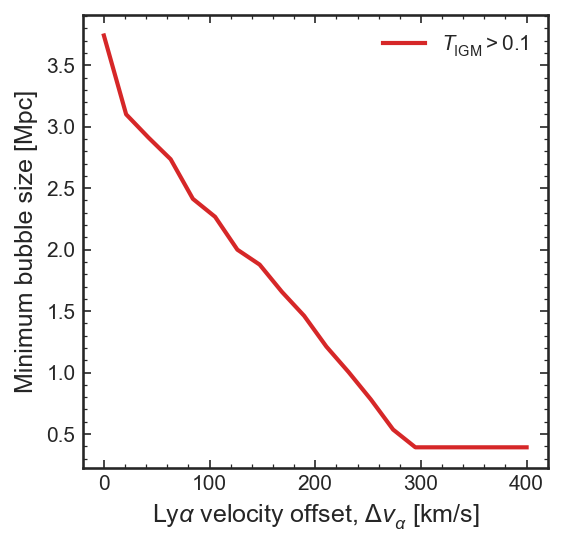

In [64]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_red[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, c='tab:red', label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav_red.pdf', bbox_inches='tight')

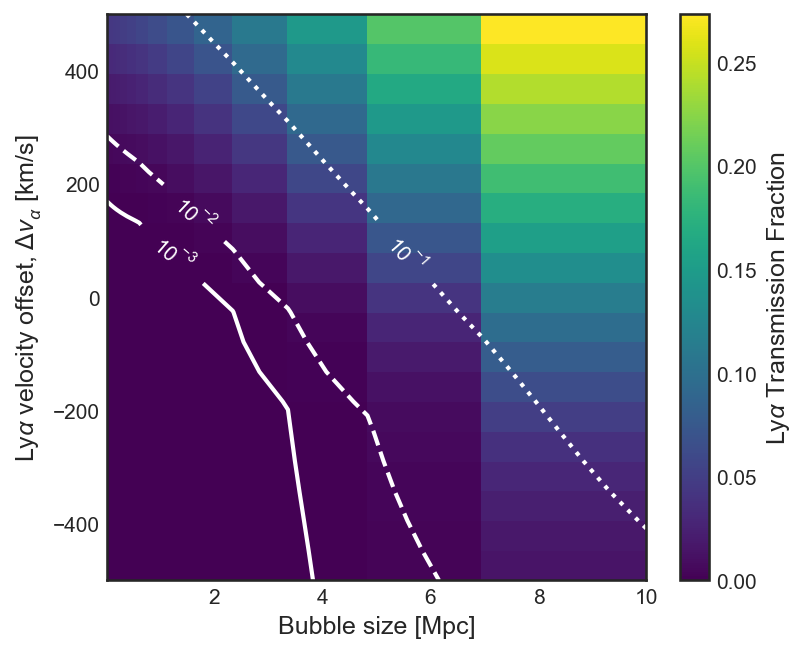

In [319]:
# reionizer.plot_image(Tigm, R_ion.value, line_DV,
#                      xlabel='Bubble size [Mpc]', 
#                      ylabel=r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]', 
#                      cmap='viridis', clabel=r'Ly$\alpha$ Transmission Fraction')

plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion.value, line_DV, Tigm, cmap='viridis')
plt.colorbar(im, label=r'Ly$\alpha$ Transmission Fraction')

Tigm_levels = [0.001, 0.01, 0.1]
cs = plt.contour(R_ion.value, line_DV, Tigm, levels=Tigm_levels, 
                 colors='w', linestyles=['solid', 'dashed', 'dotted'])

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, fmt=fmt, inline_spacing=20.)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav.pdf', bbox_inches='tight')

Text(0, 0.5, 'Lya transmission')

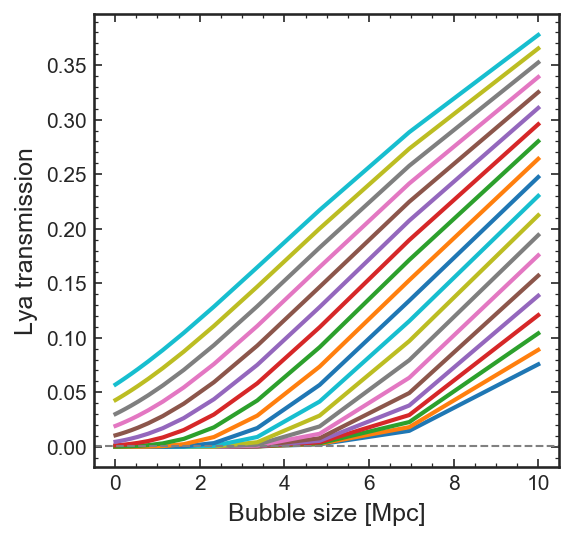

In [320]:
for i, line in enumerate(lines):
    plt.plot(R_ion, Tigm[i])
plt.axhline(1e-3, c='0.5', ls='dashed', lw=1)
plt.xlabel('Bubble size [Mpc]')
plt.ylabel('Lya transmission')

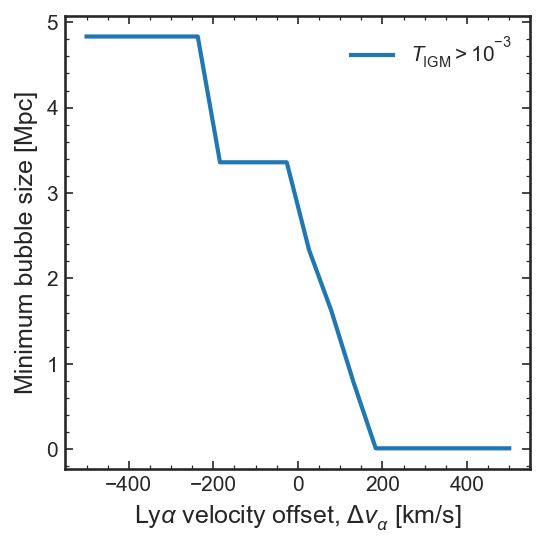

In [321]:
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion[np.where(Tigm[i] >= 1.e-3)[0][0]].value

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > 10^{-3}$')

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## Grid of R_HII, xHI(0.1 Mpc) transmissions

In [91]:
trans_dict =  {}
for i, line in enumerate(lines):
    
    trans_dict[line_DV[i]] = {}
    for keys in tau_total_dict.keys():
    
        trans_tot_tab = np.exp(-tau_total_dict[keys])
        
        transmitted_line = line*trans_tot_tab.T
        
        Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
        Tigm_blue_grid = 2*np.trapz(transmitted_line[velocity < 0.], velocity[velocity < 0.])
        Tigm_red_grid  = 2*np.trapz(transmitted_line[velocity >= 0.], velocity[velocity >= 0.])
        
        trans_dict[line_DV[i]][keys] = [Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid]

### What is minimum R_HII and max xHI where DV is observable?

In [99]:
T_min = 0.1
T_min01 = 0.01

R_xHI_trans_blue = {}
R_xHI_trans_red  = {}
for DV in trans_dict.keys():
    
    R_xHI_trans_blue[DV,T_min]  = []
    R_xHI_trans_blue[DV,T_min01]  = []
    R_xHI_trans_red[DV,T_min] = []
    R_xHI_trans_red[DV,T_min01] = []
    
    for keys in trans_dict[DV].keys():
        
        Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid = trans_dict[DV][keys]
        
        if Tigm_blue_grid > T_min:
            R_xHI_trans_blue[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min:
            R_xHI_trans_red[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_blue_grid > T_min01:
            R_xHI_trans_blue[DV,T_min01].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min01:
            R_xHI_trans_red[DV,T_min01].append([keys[0].value, keys[1]])
            
    R_xHI_trans_blue[DV,T_min] = np.array(R_xHI_trans_blue[DV,T_min])
    R_xHI_trans_red[DV,T_min]  = np.array(R_xHI_trans_red[DV,T_min])
    
    R_xHI_trans_blue[DV,T_min01] = np.array(R_xHI_trans_blue[DV,T_min01])
    R_xHI_trans_red[DV,T_min01]  = np.array(R_xHI_trans_red[DV,T_min01])

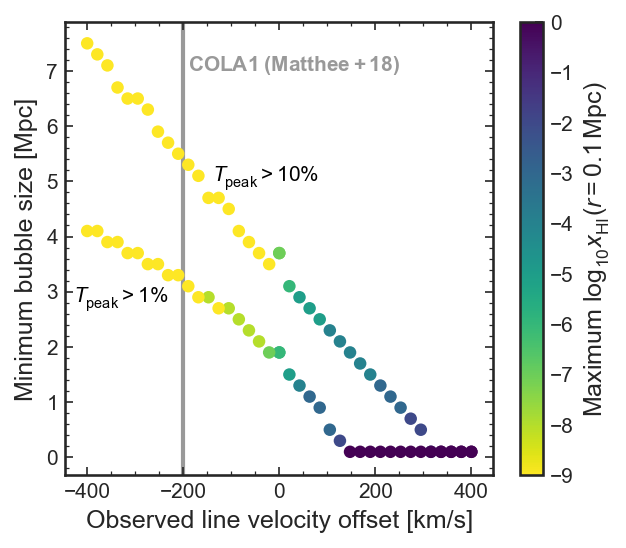

In [115]:
# Change xHI
s_m = bubbles.scalar_mappable(np.log10(xHI_01_tab), cmap='viridis_r')

plt.figure(figsize=(4.6,4))

observed_DV_tab_T_min = []
min_R_HII_tab_T_min   = []
max_xHI_tab_T_min     = []
observed_DV_tab_T_min01 = []
min_R_HII_tab_T_min01   = []
max_xHI_tab_T_min01     = []
for DV in trans_dict.keys():
    # T_min
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min][np.where(R_xHI_trans_blue[DV,T_min][:,0] == np.min(R_xHI_trans_blue[DV,T_min][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min][np.where(R_xHI_trans_red[DV,T_min][:,0] == np.min(R_xHI_trans_red[DV,T_min][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min.append([-DV])
    min_R_HII_tab_T_min.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min.append([DV])
    min_R_HII_tab_T_min.append(red_max_xHI_array[0])
    max_xHI_tab_T_min.append(red_max_xHI_array[1])
    
    # T_min_01
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min01][np.where(R_xHI_trans_blue[DV,T_min01][:,0] == np.min(R_xHI_trans_blue[DV,T_min01][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min01][np.where(R_xHI_trans_red[DV,T_min01][:,0] == np.min(R_xHI_trans_red[DV,T_min01][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min01.append([-DV])
    min_R_HII_tab_T_min01.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min01.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min01.append([DV])
    min_R_HII_tab_T_min01.append(red_max_xHI_array[0])
    max_xHI_tab_T_min01.append(red_max_xHI_array[1])

observed_DV_tab = np.array(observed_DV_tab)
min_R_HII_tab   = np.array(min_R_HII_tab)
max_xHI_tab     = np.array(max_xHI_tab)

plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min*100), xy=(-140, 5), xycoords='data', color='k')
plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min01*100), xy=(-430, 2.8), xycoords='data', color='k')

plt.scatter(observed_DV_tab_T_min, min_R_HII_tab_T_min, c=s_m.to_rgba(max_xHI_tab_T_min))
plt.scatter(observed_DV_tab_T_min01, min_R_HII_tab_T_min01, c=s_m.to_rgba(max_xHI_tab_T_min01))

plt.axvline(-200., lw=2, c='0.6', zorder=0)
plt.annotate('$\mathbf{COLA1\;(Matthee+18)}$', xy=(-200+10, 7), xycoords='data', color='0.6')

plt.colorbar(s_m, label='Maximum $\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
plt.xlabel('Observed line velocity offset [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')
# plt.yscale('log')
plt.savefig('../figs/transmission_bubblesize_deltav_xHI_linear.pdf', bbox_inches='tight')

### What is minimum DV observable given R_HII and xHI?

In [137]:
trans_minDV_dict = {}

for keys in tau_total_dict.keys():
    
    trans_tot_tab = np.exp(-tau_total_dict[keys])
    
    DV_trans = []
    for i, line in enumerate(lines):
        
        transmitted_line = line*trans_tot_tab.T
        
        Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
        Tigm_blue_grid = 2*np.trapz(transmitted_line[velocity < 0.], velocity[velocity < 0.])
        Tigm_red_grid  = 2*np.trapz(transmitted_line[velocity >= 0.], velocity[velocity >= 0.])
        
        if Tigm_blue_grid > T_min:
            DV_trans.append(-line_DV[i])
        elif Tigm_red_grid > T_min:
            DV_trans.append(line_DV[i])

    DV_trans = np.array(DV_trans)
    
    try:
        trans_minDV_dict[keys] = np.min(DV_trans)
    except:
        trans_minDV_dict[keys] = np.nan

In [222]:
def dict_to_image(dictionary, x, y):
    image = np.zeros((len(y), len(x)))
    for (i, yy), (j, xx) in it.product(enumerate(y), enumerate(x)):
        image[i, j] = dictionary[(xx,yy)]
        
    return image

Text(0, 0.5, '$\\log_{10} x_\\mathrm{HI} (r=0.1\\,$Mpc$)$')

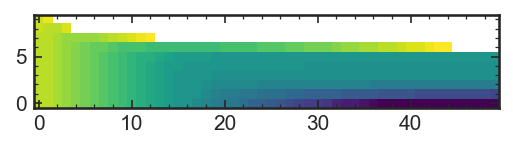

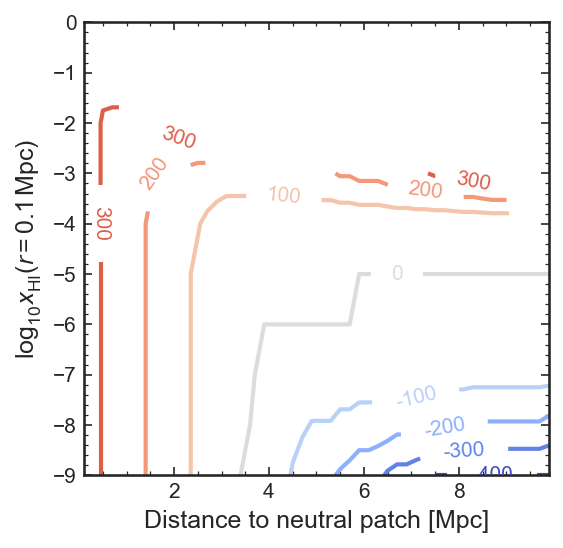

In [228]:
trans_minDV_im = dict_to_image(trans_minDV_dict, x=np.round(R_ion_tab,2), y=np.log10(xHI_01_tab))

plt.imshow(trans_minDV_im)

plt.figure()
trans_minDV_levels = np.arange(-400,401,100)

cs = plt.contour(R_ion_tab, np.log10(xHI_01_tab), trans_minDV_im, 
            levels=trans_minDV_levels, cmap='coolwarm')
plt.clabel(cs, cs.levels, fmt='%.0f', inline_spacing=20.)

plt.xlabel('Distance to neutral patch [Mpc]')
plt.ylabel('$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')

[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5
 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3 5.5 5.7 5.9 6.1 6.3 6.5 6.7 6.9 7.1
 7.3 7.5 7.7 7.9 8.1 8.3 8.5 8.7 8.9 9.1 9.3 9.5 9.7 9.9]
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.]


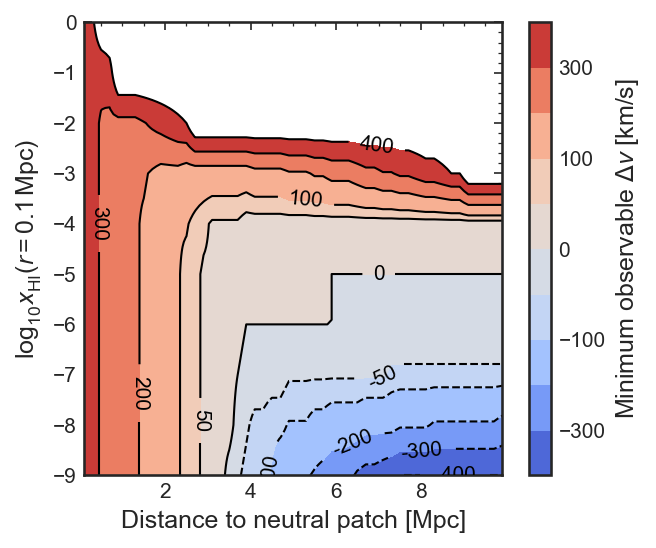

In [292]:
print(R_ion_tab.value)
print(np.log10(xHI_01_tab))
trans_minDV_im[np.isnan(trans_minDV_im)] = 600.
trans_minDV_im_interp = scipy.interpolate.interp2d(R_ion_tab.value, np.log10(xHI_01_tab), trans_minDV_im, 
                                                   kind='linear', fill_value=500.)

R_ion_tab_better = np.arange(0.1, 10, 0.1)
log10_xHI_01_tab_better = np.linspace(-9,0,100)

trans_minDV_im_interp_better = trans_minDV_im_interp(R_ion_tab_better, log10_xHI_01_tab_better)
# plt.imshow(trans_minDV_im_interp_better, cmap='coolwarm')

plt.figure(figsize=(4.5, 4))
trans_minDV_levels = [-400, -300, -200, -100, -50, 0., 50, 100, 200, 300, 400]

cs = plt.contourf(R_ion_tab_better, log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, cmap='coolwarm')#'coolwarm')

plt.colorbar(label=r'Minimum observable $\Delta v$ [km/s]')

cs = plt.contour(R_ion_tab_better, log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, linewidths=1, colors='k')#cmap='RdYlBu')#'coolwarm')

plt.clabel(cs, cs.levels, fmt='%.0f', inline_spacing=10.)

plt.xlabel('Distance to neutral patch [Mpc]')
plt.ylabel('$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')

plt.savefig('../figs/minimum_observable_DV.pdf', bbox_inches='tight')

In [337]:
18-24

-6

In [316]:
(np.pi * (const.e.esu)**2./(const.m_e * const.c)).to(u.cm**2/u.s) * (1216.*u.Angstrom).to(u.cm) * 0.416

<Quantity 1.3425463e-07 cm3 / s>

In [319]:
Planck15.H(z=7).to(1./u.s)
# (1000*u.km/u.s/u.Mpc).to(1./u.s)

<Quantity 2.76973211e-17 1 / s>

# Ionizing background model Khaire & Srianand 2019

[Khaire & Srianand 2019](https://arxiv.org/abs/1801.09693) fiducial quasar SED $\alpha=-1.8$. Which was found to reproduce the measured He II Lyman-α effective optical depths as a function of z and the epoch of He II reionization

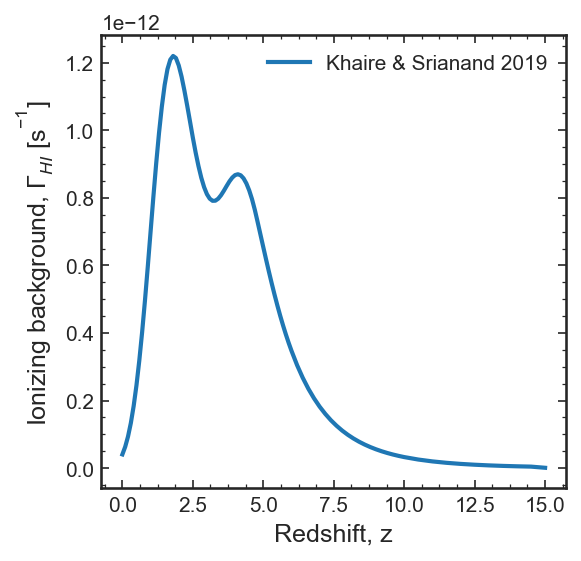

In [31]:
bubbles.ionizing_sources.plot_Gamma12_bg()